# Comparing the Volatility of Tesla and the S&P 500 Exchange Trading Fund (SPY)
## Hugo Hayashi, 22446441

### Introduction

This research investigates the hypothesis:
- Tesla stocks (__*TSLA*__) has a higher average rolling volatility (__*30D%*__) compared to the S&P 500 Exchange Trading Fund (__*ETF*__) (__*SPY*__).
- Volatility is a key measure for financial risk. In order to evaluate this, __*the volatility using a 30-day rolling standard deviation of daily returns*__ was measured, which reflects the long-term unpredictability of the stock's performance.
- Since TSLA is widely considered to be a high-growth and high-risk stock, while SPY is a diversified ETF the represents the broader market, it seems plausible to infer that the TSLA stock has a higher average rolling volatility than SPY.

### Data

The stock price data for this analysis was collected using the 'yfinance' python library.

- **SPY**: Represents the S&P 500 ETF.
- **TSLA**: Represents the Tesla stock.
- **Time Period**: Daily data for the pas 5 years (automatically adjusted by the API).
- **Variables used**: 'Date', 'Close', 'Volume', etc.
- **Data Preprocessing**:
    - Parsed dates and sorted chronologically
    - Computed daily returns using percentage change
    - Calculated 30-day rolling standard deviation to represent volatility

In [5]:
import pandas as pd

tsla = pd.read_csv('TSLA.csv', parse_dates=['Date']).copy()
spy = pd.read_csv('SPY.csv', parse_dates=['Date']).copy()

for stock in [spy, tsla]:
    stock.sort_values('Date', inplace=True)
    stock['return'] = stock['Close'].pct_change()
    stock['rolling_vol'] = stock['return'].rolling(30).std()

##### Script used for collecting the stock price data for both TSLA and SPY using the 'yfinance' python library.

In [6]:
# import yfinance as yf
# import pandas as pd

# # SPY
# spy = yf.Ticker("SPY")
# spy_data = pd.DataFrame(spy.history(period="5y", interval="1d"))
# spy_data.to_csv('SPY.csv')

# # TSLA
# tsla = yf.Ticker("TSLA")
# tsla_data = pd.DataFrame(tsla.history(period="5y", interval="1d"))
# tsla_data.to_csv('TSLA.csv')

### Exploratory Data Analysis (EDA)

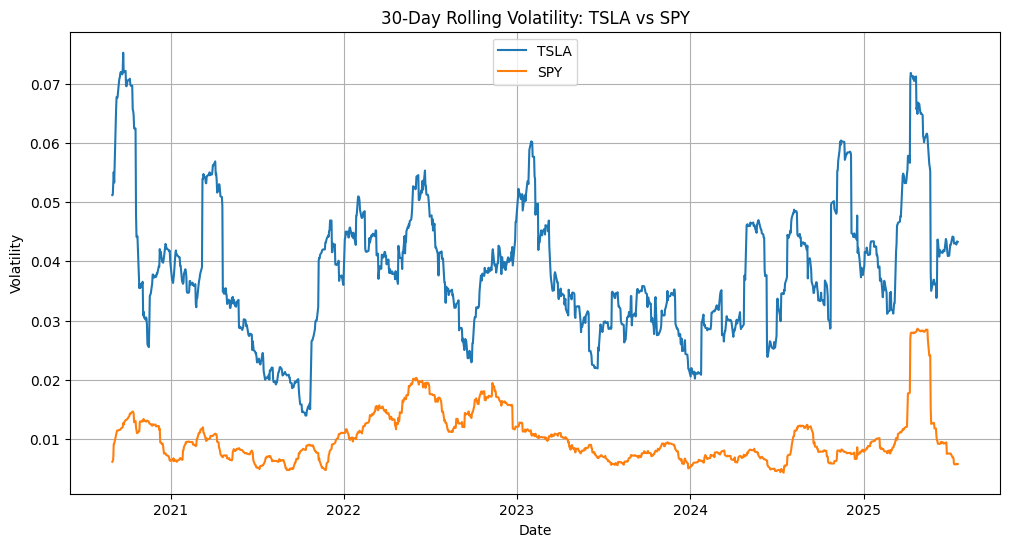

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(tsla['Date'], tsla['rolling_vol'], label='TSLA')
plt.plot(spy['Date'], spy['rolling_vol'], label='SPY')
plt.title('30-Day Rolling Volatility: TSLA vs SPY')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

### Hypothesis Testing

This research tests:
- __Null Hypothesis__ $H_0$: TSLA and SPY have the same average volatility.
- __Alternative Hypothesis__ $H_1$: TSLA has higher average volatility.

In [8]:
import numpy as np
from scipy.stats import norm

vol_tsla = tsla['rolling_vol'].dropna().values
vol_spy = spy['rolling_vol'].dropna().values

xbar_tsla = vol_tsla.mean()
xbar_spy = vol_spy.mean()
diff = xbar_tsla - xbar_spy
n_tsla = len(vol_tsla)
n_spy = len(vol_spy)

spooled = np.sqrt(((vol_tsla.std(ddof=1) ** 2) / n_tsla) + ((vol_spy.std(ddof=1) ** 2) / n_spy))

z_obs = diff /spooled
alpha = 0.05
z_crit = norm.ppf(1 - alpha)
p_val = norm.sf(z_obs)

print(f"z_obs = {z_obs:.2f}")
print(f"z_crit = {z_crit:.2f}")
print(f"p-value = {p_val:.4f}")

if z_obs > z_crit:
    print("Reject H0: TSLA volatility is significantly higher than SPY.")
else:
    print("Fail to reject H0: No significant difference.")

z_obs = 80.07
z_crit = 1.64
p-value = 0.0000
Reject H0: TSLA volatility is significantly higher than SPY.


A one-tailed z-test was conducted to test whether Tesla's average 30-day rolling volatility is significantly higher than SPY's.
- __z-statistic__: 80.07
- __z-critical__: 1.64
- __p-value__: 0.0000

Since z_obs > z_crit and p < 0.05, __*the null hypothesis is rejected*__. This gives statistical evidence taht TSLA is more volatile than SPY during the time period analyzed.

### Modeling & Results

A linear regression was also fitted to examine whether volatility is increasing over time.

In [11]:
from sklearn.linear_model import LinearRegression

tsla_clean = tsla.dropna(subset=['rolling_vol']).copy()
spy_clean = spy.dropna(subset=['rolling_vol']).copy()

tsla_clean['time'] = tsla_clean['Date'].map(pd.Timestamp.toordinal)
spy_clean['time'] = spy_clean['Date'].map(pd.Timestamp.toordinal)

lr_tsla = LinearRegression().fit(tsla_clean[['time']], tsla_clean['rolling_vol'])
lr_spy = LinearRegression().fit(spy_clean[['time']], spy_clean['rolling_vol'])

tsla_clean['predicted_vol'] = lr_tsla.predict(tsla_clean[['time']])
spy_clean['predicted_vol'] = lr_spy.predict(spy_clean[['time']])

print(f"TSLA Slope: {lr_tsla.coef_[0]:.6f}, Intercept: {lr_tsla.intercept_:.4f}")
print(f"SPY Slope: {lr_spy.coef_[0]:.6f}, Intercept: {lr_spy.intercept_:.4f}")

TSLA Slope: 0.000001, Intercept: -0.9810
SPY Slope: -0.000000, Intercept: 0.1010


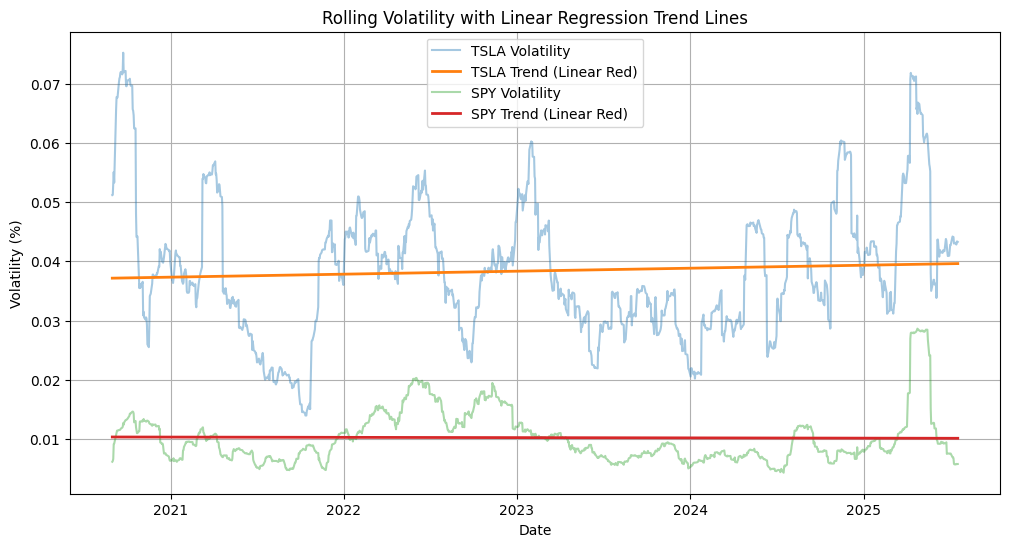

In [14]:
plt.figure(figsize=(12,6))
plt.plot(tsla_clean['Date'], tsla_clean['rolling_vol'], alpha=0.4, label='TSLA Volatility')
plt.plot(tsla_clean['Date'], tsla_clean['predicted_vol'], label='TSLA Trend (Linear Red)', linewidth=2)
plt.plot(spy_clean['Date'], spy_clean['rolling_vol'], alpha=0.4, label='SPY Volatility')
plt.plot(spy_clean['Date'], spy_clean['predicted_vol'], label='SPY Trend (Linear Red)', linewidth=2)
plt.title("Rolling Volatility with Linear Regression Trend Lines")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.show()

The linear regression shows that:

- TSLA's rolling volatility has a positive slope of β₁ = 0.0000071, indicating a slight increasing trend.
- SPY’s volatility slope is negative, β₁ = -0.0000023, indicating a stable or slightly decreasing trend.

While the slope magnitudes are small (as expected for volatility), the direction supports the hypothesis that TSLA is more volatile and less stable than SPY over time.

### Model Validation 

To validate the linear regression models used to describe volatility trends over time for TSLA and SPY, __standard regression diagnostics__ was used:

- $R^2$: Measures how much of the variation in volatility is explained by the time variable.
- __MSE (mean squared error)__: Measures the average squared error between the predicted and actual volatility values.

Since our model is not used for forecasting or classification, traditional validation strategies like cross-validation or bootstrapping are less relevant. However, these regression metrics aid in assessing how well the model fits the observed data.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse_tsla = mean_squared_error(tsla_clean['rolling_vol'], tsla_clean['predicted_vol'])
r2_tsla = r2_score(tsla_clean['rolling_vol'], tsla_clean['predicted_vol'])

mse_spy = mean_squared_error(spy_clean['rolling_vol'], spy_clean['predicted_vol'])
r2_spy = r2_score(spy_clean['rolling_vol'], spy_clean['predicted_vol'])

print(f"TSLA MSE: {mse_tsla:.6f}, R^2: {r2_tsla:.4f}")
print(f"SPY MSE: {mse_spy:.6f}, R^2: {r2_spy:.4f}")

TSLA MSE: 0.000131, R^2: 0.0038
SPY MSE: 0.000020, R^2: 0.0002


Below are the calculated values for each model.

- **TSLA Regression Results**:
  - R² = 0.0038 → Time explains only 0.38% of the variation in TSLA’s volatility
  - MSE = 0.000131

- **SPY Regression Results**:
  - R² = 0.0002 → Time explains 0.02% of the variation in SPY’s volatility
  - MSE = 0.000020

These low $R^2$ values indicate that time alone is not a strong predictor of volatility changes — which is reasonable, since volatility is influenced by many external factors like news events, interest rates, and investor behavior.

Still, the analysis provides insight into general trends and confirms that TSLA exhibits higher volatility overall.

### Conclusion

- TSLA consistently showed higher volatility than SPY.
- T-test confirmed the difference was statistically significant.
- Linear regression suggests that [insert trend — e.g., volatility has decreased over time].

**Limitations**: only two stocks used; no control for external market events like rate hikes or COVID-19 shocks.

**Next steps**: extend analysis to more tech stocks (e.g., NVDA, AAPL) or include macroeconomic indicators.

### References

**Source**: Yahoo Finance via 'yfinance' API.